In [7]:
import gmsh
import numpy as np

gmsh.initialize()
gmsh.model.add("torus")

# Parameters for the torus
R = 1.0   # Major radius
r = 0.3   # Minor radius

# Create the torus geometry
torus = gmsh.model.occ.addTorus(0, 0, 0, R, r)
gmsh.model.occ.synchronize()

# Mesh settings
gmsh.model.mesh.setSize(gmsh.model.getEntities(0), 0.15)

# Generate the mesh
gmsh.model.mesh.generate(3)

# ✅ AFTER mesh generation: now extract surface entities
surfaces = gmsh.model.getEntities(dim=2)

# Tagging the Surfaces
outer_surface, inner_surface = None, None

for surface in surfaces:
    nodes, coords, _ = gmsh.model.mesh.getNodes(dim=2, tag=surface[1])
    coords = np.array(coords).reshape(-1, 3)

    avg_distance = np.mean(np.linalg.norm(coords, axis=1))
    
    if avg_distance > R:
        outer_surface = surface[1]
    else:
        inner_surface = surface[1]

# Add physical tags
if outer_surface:
    gmsh.model.addPhysicalGroup(2, [outer_surface], tag=2)
    gmsh.model.setPhysicalName(2, 2, "OuterSurface")

if inner_surface:
    gmsh.model.addPhysicalGroup(2, [inner_surface], tag=3)
    gmsh.model.setPhysicalName(2, 3, "InnerSurface")

# Also tag the 3D volume
volumes = gmsh.model.getEntities(dim=3)
gmsh.model.addPhysicalGroup(3, [v[1] for v in volumes], tag=1)
gmsh.model.setPhysicalName(3, 1, "domain")

# Save the mesh to a .msh file
gmsh.write("torus.msh")
print("Mesh has been written to torus.msh")

gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 60%] Meshing curve 2 (Circle)
Info    : Done meshing 1D (Wall 0.000270958s, CPU 0.000372s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Torus, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0300682s, CPU 0.030144s)
Info    : Meshing 3D...
Info    : 3D Meshing 1 volume with 1 connected component
Info    : Tetrahedrizing 658 nodes...
Info    : Done tetrahedrizing 666 nodes (Wall 0.00514262s, CPU 0.005095s)
Info    : Reconstructing mesh...
Info    :  - Creating surface mesh
Info    :  - Identifying boundary edges
Info    :  - Recovering boundary
Info    : Done reconstructing mesh (Wall 0.0126544s, CPU 0.012536s)
Info    : Found volume 1
Info    : It. 0 - 0 nodes created - worst tet radius 2.16664 (nodes removed 0 0)
Info    : 3D refinement terminated (839 nodes total):
Info    :  - 0 Delaunay cavities modified for star shapeness
Info    :  - 0 nodes could not be inserted
Info    :  - 2883 tetrahedra

Info    : Reading 'torus.msh'...
Info    : 5 entities
Info    : 839 nodes
Info    : 4144 elements
Info    : Done reading 'torus.msh'
L2-norm of residual ||∇×B − μB − f|| = 1.32e+00
∫ B · n ds over boundary: 1.31e-06
∫ (B · n)² ds over boundary: 7.14e-08
Reference Bx at (1,0,0): 6.9398e-02
Volume of domain: 1.723238
∫ x · n ds over boundary: 5.169714
3 × Volume: 5.169714
Error in identity: 6.22e-15


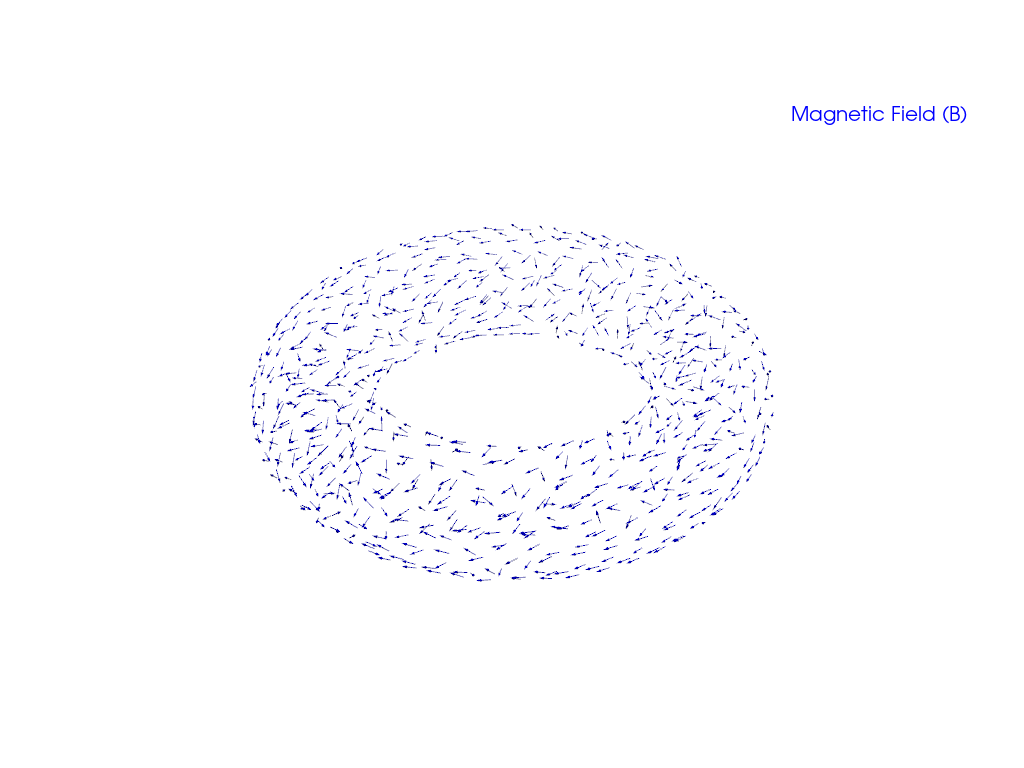

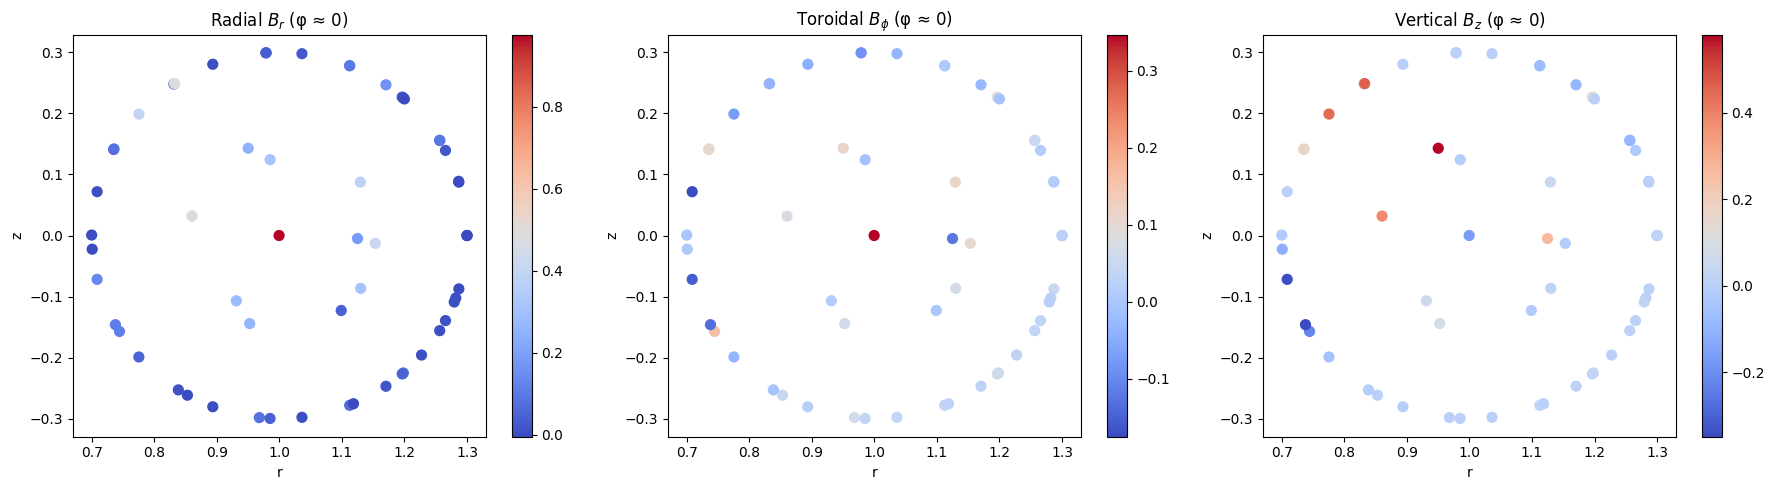

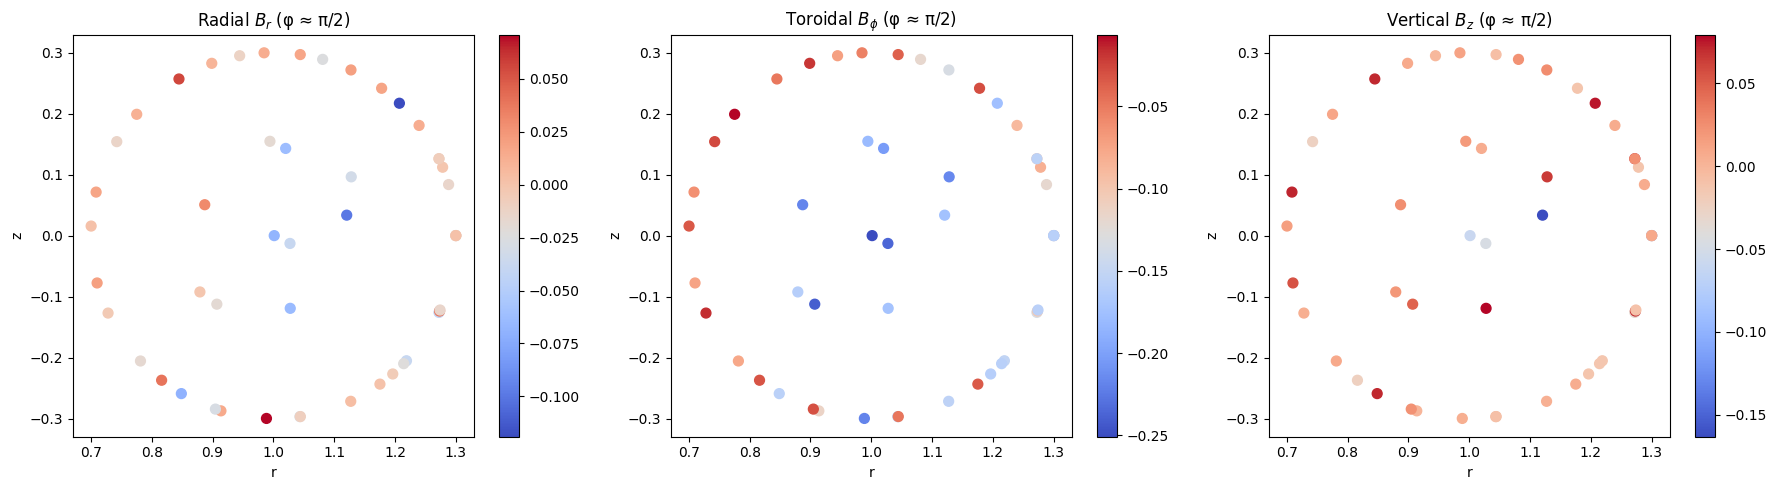

In [8]:
from dolfinx import fem
from mpi4py import MPI
from dolfinx.io import gmshio
from dolfinx.io import XDMFFile
from ufl import curl, inner, cross, dx, ds, FacetNormal, TrialFunction, TestFunction, CellDiameter
from petsc4py import PETSc
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from dolfinx.fem import form, assemble_scalar, Constant
from ufl import dot, as_vector

# ================================
# 1. Read the mesh from Gmsh
# ================================
domain, cell_tags, facet_tags = gmshio.read_from_msh("torus.msh", MPI.COMM_WORLD, gdim=3)

# ================================
# 2. Define Function Space
# ================================
V = fem.functionspace(domain, ("N1curl", 1, (domain.topology.dim,)))

# ================================
# 3. Define Weak Form (Beltrami with Nitsche BC)
# ================================
u = TrialFunction(V)
v = TestFunction(V)
n = FacetNormal(domain)
mu = 0.5  # Magnetic permeability
gamma = 20000.0  # Penalty parameter
h = CellDiameter(domain)

un = inner(u, n)
vn = inner(v, n)

a = (
    inner(curl(u), curl(v)) * dx
    - mu**2 * inner(u, v) * dx
    - inner(cross(n, u), v) * ds
    - inner(cross(n, v), u) * ds
    + gamma / h * un * vn * ds
)

f = fem.Constant(domain, PETSc.ScalarType((1, 0, 0)))
L = inner(f, v) * dx

# ================================
# 4. Solve the Linear Problem
# ================================
from dolfinx.fem.petsc import LinearProblem
problem = LinearProblem(a, L, bcs=[], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()
# ================================
# ================================

# Step 1: Compute the curl of the magnetic field (uh) symbolically
curl_uh_expr = curl(uh)  # This is a UFL expression representing ∇×B

# Step 2: Define the forcing term f as a constant vector field
f_expr = Constant(domain, PETSc.ScalarType((1.0, 0.0, 0.0)))  # You can change this if needed

# Step 3: Define the residual expression: r(x) = ∇×B - μB - f
residual_expr = curl_uh_expr - mu * uh - f_expr

# Step 4: Form the squared L²-norm of the residual over the domain
residual_L2_sq_form = form(inner(residual_expr, residual_expr) * dx)

# Step 5: Assemble the scalar value of the L²-norm squared
residual_L2_sq = assemble_scalar(residual_L2_sq_form)

# Step 6: Print the final L²-norm of the residual
print(f"L2-norm of residual ||∇×B − μB − f|| = {residual_L2_sq**0.5:.2e}")
# ================================
# 5. Check Boundary Condition: B · n ≈ 0
# ================================
B_dot_n = inner(uh, n) * ds
b_normal_integral = assemble_scalar(form(B_dot_n))
print(f"∫ B · n ds over boundary: {b_normal_integral:.2e}")

B_dot_n_sq = inner(uh, n)**2 * ds
b_dot_n_sq_integral = assemble_scalar(form(B_dot_n_sq))
print(f"∫ (B · n)² ds over boundary: {b_dot_n_sq_integral:.2e}")

# ================================
# 6. Normalize Field in CG Space
# ================================
V_cg = fem.functionspace(domain, ("Lagrange", 1, (domain.topology.dim,)))
uh_cg = fem.Function(V_cg)
uh_cg.interpolate(uh)

points = V_cg.tabulate_dof_coordinates().reshape(-1, 3)
target_point = np.array([1.0, 0.0, 0.0])
distances = np.linalg.norm(points - target_point, axis=1)
closest_index = np.argmin(distances)

uh_values = uh_cg.x.array.reshape(-1, 3)
reference_value = uh_values[closest_index, 0]

if abs(reference_value) < 1e-14:
    raise RuntimeError("Reference value too small to normalize")

uh_values /= reference_value
print(f"Reference Bx at (1,0,0): {reference_value:.4e}")
uh_cg.x.array[:] = uh_values.flatten()
uh_cg.x.scatter_forward()


# ================================
# 7. Verify Volume Identity: ∫ x · n = 3 * Volume
# ================================
one = Constant(domain, PETSc.ScalarType(1.0))
volume = assemble_scalar(form(one * dx))
print(f"Volume of domain: {volume:.6f}")

V_scalar = fem.functionspace(domain, ("Lagrange", 1))
x_fn = fem.Function(V_scalar); x_fn.interpolate(lambda x: x[0])
y_fn = fem.Function(V_scalar); y_fn.interpolate(lambda x: x[1])
z_fn = fem.Function(V_scalar); z_fn.interpolate(lambda x: x[2])

vec_x = as_vector((x_fn, y_fn, z_fn))
x_dot_n_form = dot(vec_x, n) * ds
x_dot_n_integral = assemble_scalar(form(x_dot_n_form))

print(f"∫ x · n ds over boundary: {x_dot_n_integral:.6f}")
print(f"3 × Volume: {3*volume:.6f}")
print(f"Error in identity: {abs(x_dot_n_integral - 3 * volume):.2e}")

# ================================
# 8. Save Field to File
# ================================
with XDMFFile(MPI.COMM_WORLD, "B_solution.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain)
    xdmf.write_function(uh_cg)

# ================================
# 9. Extract Cylindrical Components (B_r, B_phi, B_z)
# ================================
vectors = uh_cg.x.array.reshape(-1, 3)
x, y, z = points[:, 0], points[:, 1], points[:, 2]
r = np.sqrt(x**2 + y**2)
r_safe = np.where(r > 1e-14, r, 1.0)

e_r = np.column_stack((x / r_safe, y / r_safe, np.zeros_like(z)))
e_phi = np.column_stack((-y / r_safe, x / r_safe, np.zeros_like(z)))
e_z = np.column_stack((np.zeros_like(x), np.zeros_like(y), np.ones_like(z)))

B_r = np.einsum("ij,ij->i", vectors, e_r)
B_phi = np.einsum("ij,ij->i", vectors, e_phi)
B_z = vectors[:, 2]

# ================================
# 10. Visualize Vector Field
# ================================
norms = np.linalg.norm(vectors, axis=1)
normalized_vectors = np.zeros_like(vectors)
nonzero = norms > 1e-14
normalized_vectors[nonzero] = (vectors[nonzero].T / norms[nonzero]).T

cloud = pv.PolyData(points)
cloud["B"] = normalized_vectors
cloud["B_magnitude"] = np.linalg.norm(vectors, axis=1)

surf = cloud.extract_surface()
glyphs = surf.glyph(orient="B", factor=0.07)

p = pv.Plotter()
p.add_mesh(glyphs, color="blue")
p.add_legend([("Magnetic Field (B)", "blue")])
p.show()
# ================================

# Extract a toroidal cross-section near φ ≈ 0 (i.e., y ≈ 0)
phi = np.arctan2(y, x)
r = np.sqrt(x**2 + y**2)
r_safe = np.where(r > 1e-14, r, 1.0)

e_r = np.column_stack((x / r_safe, y / r_safe, np.zeros_like(z)))
e_phi = np.column_stack((-y / r_safe, x / r_safe, np.zeros_like(z)))
e_z = np.column_stack((np.zeros_like(x), np.zeros_like(y), np.ones_like(z)))

B_r = np.einsum("ij,ij->i", vectors, e_r)
B_phi = np.einsum("ij,ij->i", vectors, e_phi)
B_z = vectors[:, 2]
# ================================
# 13. Cross-Section Plots for φ ≈ 0 and φ ≈ π/2
# ================================
phi0_mask = np.abs(phi) < 0.2
phi90_mask = np.abs(phi - np.pi/2) < 0.2

def plot_cross_section(phi_mask, title_suffix, filename_suffix):
    r_slice = r[phi_mask]
    z_slice = z[phi_mask]
    Br_slice = B_r[phi_mask]
    Bphi_slice = B_phi[phi_mask]
    Bz_slice = B_z[phi_mask]

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    sc1 = axs[0].scatter(r_slice, z_slice, c=Br_slice, cmap="coolwarm", s=50)
    axs[0].set_title(f"Radial $B_r$ ({title_suffix})")
    axs[0].set_xlabel("r"); axs[0].set_ylabel("z")
    plt.colorbar(sc1, ax=axs[0])

    sc2 = axs[1].scatter(r_slice, z_slice, c=Bphi_slice, cmap="coolwarm", s=50)
    axs[1].set_title(f"Toroidal $B_\\phi$ ({title_suffix})")
    axs[1].set_xlabel("r"); axs[1].set_ylabel("z")
    plt.colorbar(sc2, ax=axs[1])

    sc3 = axs[2].scatter(r_slice, z_slice, c=Bz_slice, cmap="coolwarm", s=50)
    axs[2].set_title(f"Vertical $B_z$ ({title_suffix})")
    axs[2].set_xlabel("r"); axs[2].set_ylabel("z")
    plt.colorbar(sc3, ax=axs[2])

    plt.tight_layout()
    plt.savefig(f"components_{filename_suffix}_gamma{int(gamma)}.png")
    plt.show()

plot_cross_section(phi0_mask, "φ ≈ 0", "phi_0")
plot_cross_section(phi90_mask, "φ ≈ π/2", "phi_90")


In [9]:
from dolfinx import fem, io
from mpi4py import MPI
from dolfinx.io import gmshio, XDMFFile
from ufl import finiteelement
from ufl.classes import MixedElement
from petsc4py import PETSc
from ufl import (
    TrialFunction, TestFunction, curl, inner, dx, ds, FacetNormal,
    cross, dot, CellDiameter, as_vector, split, TestFunctions, TrialFunctions
)
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt

# ===========================
# 1. Read mesh
# ===========================
domain, cell_tags, facet_tags = gmshio.read_from_msh("torus.msh", MPI.COMM_WORLD, gdim=3)

# ===========================
# 2. Function spaces: B in N1curl, λ in real
# ===========================
element_B = fem.finite_element(domain.ufl_cell(), "N1curl", 1, shape=(3,))
element_lambda = fem.finite_element(domain.ufl_cell(), "DG", 0)  # constant over domain

W_elem = MixedElement([element_B, element_lambda])
W = fem.functionspace(domain, W_elem)

(u, lmbda) = TrialFunctions(W)
(v, mu) = TestFunctions(W)

n = FacetNormal(domain)
mu_phys = 1.0
gamma = 20000.0
h = CellDiameter(domain)

# ===========================
# 3. Variational forms (Nitsche's + Lagrange multiplier)
# ===========================
un = inner(u, n)
vn = inner(v, n)

a = (
    inner(curl(u), curl(v)) * dx
    - mu_phys**2 * inner(u, v) * dx
    - inner(cross(n, u), v) * ds
    - inner(cross(n, v), u) * ds
    + gamma / h * un * vn * ds
    + lmbda * v[0] * dx
    + u[0] * mu * dx
)

L = fem.Constant(domain, PETSc.ScalarType(0.0))
rhs = L * v[0] * dx + fem.Constant(domain, PETSc.ScalarType(1.0)) * mu * dx  # only RHS for λ equation is ∫μ dx

# ===========================
# 4. Solve
# ===========================
from dolfinx.fem.petsc import LinearProblem
problem = LinearProblem(a, rhs, bcs=[], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
w_sol = problem.solve()

# Split solution
B, lambda_sol = w_sol.sub(0).collapse(), w_sol.sub(1).collapse()

# ===========================
# 5. Post-processing and verification
# ===========================
print("∫ B·n ds =", assemble_scalar(form(inner(B, n) * ds)))
print("∫ Bₓ dx =", assemble_scalar(form(B.sub(0) * dx)))

Info    : Reading 'torus.msh'...
Info    : 5 entities
Info    : 839 nodes
Info    : 4144 elements
Info    : Done reading 'torus.msh'


AttributeError: module 'dolfinx.fem' has no attribute 'finite_element'